In [1]:
import sys
# sys.stdout = open('/dev/stdout', 'w')

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

import simpy
import numpy as np
import pandas as pd

from ggplot import *

from collections import namedtuple
from simpy.util import start_delayed

%run docket.py

In [2]:
NUM_JUDGES = 80
JUDGE_TENURES = [365 * -1, 365 * -5, 365 * -99]
NUM_ATTORNEYS_PER_JUDGE_BY_TENURE = [6, 7, 8]
VAR_ATTORNEYS_PER_JUDGE = 1
AVG_NUM_ATTORNEYS_PER_JUDGE = np.mean(NUM_ATTORNEYS_PER_JUDGE_BY_TENURE)
ATTORNEY_COUNT = AVG_NUM_ATTORNEYS_PER_JUDGE * NUM_JUDGES
BATCH_SIZE_PER_ATTORNEY = 5
AVG_BATCH_SIZE = AVG_NUM_ATTORNEYS_PER_JUDGE * BATCH_SIZE_PER_ATTORNEY
BVA_ANNUAL_THROUGHPUT = 90000
AVG_DAYS_BETWEEN_DISTRIBUTION = 365 / (BVA_ANNUAL_THROUGHPUT / AVG_BATCH_SIZE / NUM_JUDGES)
SD_DAYS_BETWEEN_DISTRIBUTION = AVG_DAYS_BETWEEN_DISTRIBUTION * 0.1
DECISION_TIMELINESS_GOAL = 365
TARGET_DISTRIBUTION_TIME = DECISION_TIMELINESS_GOAL - 30
MAXIMUM_DIRECT_REVIEW_PROPORTION = 0.8
HEARING_SCHEDULE_PERIOD = 90

In [3]:
HEARING_RATE = 0.5
PRIORITY_CASE_RATE = 0.2
EVIDENCE_PRIORITY_CASE_RATE = 0.33
REMAND_RATE = 0.5
INIT_NUM_CASES = 30000
INIT_HEARING_RATE = 0.5
INIT_PRIORITY_CASE_RATE = 0.02
INIT_REMAND_RATE = 0.25
AVG_AGE_AT_ARRIVAL = 365 * 2
SD_AGE_AT_ARRIVAL = 365 * 1
AVG_REMAND_AGE_AT_ARRIVAL = 365 * 5
SD_REMAND_AGE_AT_ARRIVAL = 365 * 2.5
AGE_AT_HEARING = 365 * 2
LEGACY_ARRIVAL_RATE = 80000
AVG_LEGACY_ARRIVAL_INTERVAL = 1 / (LEGACY_ARRIVAL_RATE / 365)
SD_LEGACY_ARRIVAL_INTERVAL = AVG_LEGACY_ARRIVAL_INTERVAL * 0.2
LEGACY_ATTENUATION_START = 365 * 0.5
LEGACY_ATTENUATION_END = 365 * 3.5
LEGACY_RETURN_RATE = 0.5
AVG_REMAND_TIME = 365 * 1
SD_REMAND_TIME = AVG_REMAND_TIME * 0.25
AMA_ARRIVAL_RATE = 80000
AVG_AMA_ARRIVAL_INTERVAL = 1 / (AMA_ARRIVAL_RATE / 365)
SD_AMA_ARRIVAL_INTERVAL = AVG_AMA_ARRIVAL_INTERVAL * 0.2
AMA_RETURN_RATE = 0.25
AVG_AMA_RETURN_TIME = 365 * 1.5
SD_AMA_RETURN_TIME = AVG_AMA_RETURN_TIME * 0.33
DOCKET_PROBS = [0.45, 0.45, 0.1]

In [4]:
def jitter_round(f):
    return int(np.ceil(f) if np.random.rand() >= (f % 1) else np.floor(f))

In [5]:
def instrumented_get_nonpriority_appeals(docket, judge = None, limit = sys.maxsize, range = sys.maxsize):
    if not isinstance(judge, list):
        judge = [judge]

    indices = [idx for idx, item in enumerate(docket.items[:range]) if item.judge in judge]
    limited_indices = indices[:limit]
    appeals = yield docket.get(limited_indices)
    return appeals, max(limited_indices, default = 0)

In [6]:
def select_appeals_for_judge(judge, env, dockets, data):
    batch_size = len(judge.attorneys) * BATCH_SIZE_PER_ATTORNEY
    total_batch_size = len(attorneys) * BATCH_SIZE_PER_ATTORNEY

In [7]:
env = simpy.Environment()

In [8]:
data = {
    'distribution_batches': [],
    'distribution_cases': [],
    'hearing_schedules': [],
    'days': []
}

In [9]:
Judge = namedtuple('Judge', 'id tenure attorneys')

def generate_judge(i):
    tenure = np.random.choice(JUDGE_TENURES)
    tenure_idx = JUDGE_TENURES.index(tenure)
    attorneys = NUM_ATTORNEYS_PER_JUDGE_BY_TENURE[tenure_idx] +\
        np.random.randint(-VAR_ATTORNEYS_PER_JUDGE, VAR_ATTORNEYS_PER_JUDGE)
    return Judge(i, tenure, attorneys)

judges = [generate_judge(i) for i in range(NUM_JUDGES)]

In [10]:
class Appeal(namedtuple('Appeal', 'docket judge priority docketed arrived')):
    def __lt__(self, other):
        return self.docketed < other.docketed
    
class PriorityAppeal(namedtuple('PriorityAppeal', 'docket judge priority docketed arrived')):
    def __lt__(self, other):
        return self.arrived < other.arrived
    
def generate_legacy_appeal(hearing_prob, priority_prob, remand_prob, now):
    judge = None
    hearing = np.random.rand() < hearing_prob
    priority = np.random.rand() < priority_prob
    remand = np.random.rand() < remand_prob
    docketed = now - (np.random.normal(AVG_REMAND_AGE_AT_ARRIVAL, SD_REMAND_AGE_AT_ARRIVAL) if remand else np.random.normal(AVG_AGE_AT_ARRIVAL, SD_AGE_AT_ARRIVAL))
    if hearing:
        valid_judges = [j for j in judges if j.tenure <= docketed + AGE_AT_HEARING]
        judge = valid_judges[np.random.randint(1, len(valid_judges)) - 1]
    if priority:
        return PriorityAppeal('legacy', judge, priority, docketed, now)
    return Appeal('legacy', judge, priority, docketed, now)

def generate_ama_appeal(docket_probs, priority_prob, evidence_priority_prob, now):
    docket = np.random.choice(['direct', 'hearing', 'evidence'], p = docket_probs)
    priority = np.random.rand() < priority_prob
    if docket == 'evidence':
        priority = np.random.rand() < evidence_priority_prob
    if priority:
        return PriorityAppeal(docket, None, priority, now, now)
    return Appeal(docket, None, priority, now, now)

In [11]:
dockets = {
    "legacy": Docket(env),
    "direct": Docket(env),
    "evidence": Docket(env),
    "hearing": Docket(env)
}

dockets["hearing"].ready = Docket(env)

dockets["legacy"].prepopulate([generate_legacy_appeal(INIT_HEARING_RATE, INIT_PRIORITY_CASE_RATE, INIT_REMAND_RATE, 0)
                               for i in range(INIT_NUM_CASES)])

True

In [12]:
def add_to_docket(env, appeal, dockets):
    if appeal.docket == 'legacy':
        appeal = appeal._replace(arrived = env.now)
    else:
        appeal = appeal._replace(arrived = env.now, docketed = env.now)
    docket = dockets[appeal.docket]
    yield docket.put(appeal)

In [13]:
def legacy_appeal_arrives(env, dockets):
    while env.now < LEGACY_ATTENUATION_END:
        interval = abs(np.random.normal(AVG_LEGACY_ARRIVAL_INTERVAL, SD_LEGACY_ARRIVAL_INTERVAL))
        yield env.timeout(interval)
        interpolant = max(env.now - LEGACY_ATTENUATION_START, 0) / (LEGACY_ATTENUATION_END - LEGACY_ATTENUATION_START)
        if np.random.rand() < interpolant:
            continue
        remand = np.random.rand() < REMAND_RATE
        appeal = generate_legacy_appeal(HEARING_RATE, PRIORITY_CASE_RATE, 1 if remand else 0, env.now)
        yield from add_to_docket(env, appeal, dockets)

legacy_arrival_proc = env.process(legacy_appeal_arrives(env, dockets))

In [14]:
def ama_appeal_arrives(env, dockets):
    while True:
        interval = abs(np.random.normal(AVG_AMA_ARRIVAL_INTERVAL, SD_AMA_ARRIVAL_INTERVAL))
        yield env.timeout(interval)
        appeal = generate_ama_appeal(DOCKET_PROBS, PRIORITY_CASE_RATE, EVIDENCE_PRIORITY_CASE_RATE, env.now)
        yield from add_to_docket(env, appeal, dockets)
        
ama_arrival_proc = env.process(ama_appeal_arrives(env, dockets))

In [15]:
def docket_proportions(env, dockets):
    total_batch_size = ATTORNEY_COUNT * BATCH_SIZE_PER_ATTORNEY
    priority_count = sum([docket.priority_count() for name, docket in dockets.items() if name != "hearing"]) + dockets["hearing"].ready.priority_count()
    docket_range_net_of_priority = total_batch_size - priority_count

    direct_review_count = dockets["direct"].nonpriority_count()
    due_direct_review_count = len([c for c in dockets["direct"].items if c.arrived <= env.now - TARGET_DISTRIBUTION_TIME])
    
    due_direct_docket_proportion = due_direct_review_count / docket_range_net_of_priority
    
    non_priority_decision_rate = BVA_ANNUAL_THROUGHPUT * (1 - PRIORITY_CASE_RATE - 0.013)
    oldest_direct_review_age = env.now - min([c.arrived for c in dockets["direct"].items], default=env.now)
    direct_review_arrival_rate = AMA_ARRIVAL_RATE * DOCKET_PROBS[0] * (1 - PRIORITY_CASE_RATE - 0.013) if oldest_direct_review_age < 30 else direct_review_count / oldest_direct_review_age * 365
    pacesetting_direct_review_percentage = direct_review_arrival_rate / non_priority_decision_rate
    direct_review_interpolation_factor = min(oldest_direct_review_age / TARGET_DISTRIBUTION_TIME, 1)
    interpolated_minimum_direct_docket_proportion = direct_review_interpolation_factor * pacesetting_direct_review_percentage
    
    direct_docket_proportion = min(max(due_direct_docket_proportion, interpolated_minimum_direct_docket_proportion), MAXIMUM_DIRECT_REVIEW_PROPORTION)
    
    legacy_adustment = (1 - min(1, env.now / (365 * 7))) * 200000

    non_direct_docket_count = sum([docket.nonpriority_count() for name, docket in dockets.items() if name != "direct"]) + dockets["hearing"].ready.nonpriority_count() + legacy_adustment
    legacy_count = dockets["legacy"].nonpriority_count()
    evidence_count = dockets["evidence"].nonpriority_count()
    hearing_count = dockets["hearing"].nonpriority_count() + dockets["hearing"].ready.nonpriority_count()

    legacy_docket_proportion = (legacy_count + legacy_adustment) / non_direct_docket_count * (1 - direct_docket_proportion)
    evidence_docket_proportion = evidence_count / non_direct_docket_count * (1 - direct_docket_proportion)
    hearing_docket_proportion = hearing_count / non_direct_docket_count * (1 - direct_docket_proportion)
    
    if legacy_docket_proportion < 0.1:
        legacy_docket_proportion = min(legacy_count / total_batch_size, 0.1)
        rem_proportion = 1 - direct_docket_proportion - legacy_docket_proportion
        rem_count = evidence_count + hearing_count
        evidence_docket_proportion = evidence_count / rem_count * rem_proportion
        hearing_docket_proportion = hearing_count / rem_count * rem_proportion
    
    return {
        "legacy": legacy_docket_proportion,
        "direct": direct_docket_proportion,
        "evidence": evidence_docket_proportion,
        "hearing": hearing_docket_proportion,
        "priority_count": priority_count,
        "direct_review_count": direct_review_count,
        "due_direct_review_count": due_direct_review_count,
        "legacy_count": legacy_count,
        "evidence_count": evidence_count,
        "hearing_count": hearing_count,
        "oldest_direct_review_age": oldest_direct_review_age,
        "due_direct_docket_proportion": due_direct_docket_proportion,
        "direct_review_arrival_rate": direct_review_arrival_rate,
        "pacesetting_direct_review_percentage": pacesetting_direct_review_percentage,
        "interpolated_minimum_direct_docket_proportion": interpolated_minimum_direct_docket_proportion
    }

def select_appeals_for_judge(env, judge, dockets, data):
    batch_size = judge.attorneys * BATCH_SIZE_PER_ATTORNEY
    total_batch_size = ATTORNEY_COUNT * BATCH_SIZE_PER_ATTORNEY
    
    priority_count = sum([docket.priority_count() for name, docket in dockets.items() if name != "hearing"]) + dockets["hearing"].ready.priority_count()
    priority_percentage = priority_count / total_batch_size
    docket_range_net_of_priority = total_batch_size - priority_count
    
    proportions = docket_proportions(env, dockets)
    
    rem = batch_size

    priority_legacy_hearing_appeals = yield dockets["legacy"].get_priority_appeals(judge = judge, limit = rem)
    rem -= len(priority_legacy_hearing_appeals)
    
    priority_ama_hearing_appeals = yield dockets["hearing"].ready.get_priority_appeals(judge = judge, limit = rem)
    rem -= len(priority_ama_hearing_appeals)
    
    nonpriority_legacy_hearing_range = int(round(docket_range_net_of_priority * proportions["legacy"]))
    nonpriority_legacy_hearing_appeals, max_index_1 = yield from instrumented_get_nonpriority_appeals(docket = dockets["legacy"],
                                                                                                      judge = judge,
                                                                                                      limit = rem,
                                                                                                      range = nonpriority_legacy_hearing_range)
    
    rem -= len(nonpriority_legacy_hearing_appeals)
    
    nonpriority_ama_hearing_appeals = yield dockets["hearing"].ready.get_nonpriority_appeals(judge = judge, limit = rem)
    rem -= len(nonpriority_ama_hearing_appeals)
    
    priority_count = len(priority_legacy_hearing_appeals) + len(priority_ama_hearing_appeals)
    rem_priority = jitter_round(min(rem, max(0, priority_percentage * batch_size - priority_count)))
    
    other_priority_appeals = []
    
    while rem_priority > 0:
        docket_name = sorted([(name, docket.oldest_genpop_priority_case_age()) for name, docket in dockets.items() if name != "hearing"], key=lambda x: x[1])[0][0]
        docket = dockets[docket_name]
        additional_priority_appeals = yield docket.get_priority_appeals(limit = 1)
        if len(additional_priority_appeals) == 0: break
        other_priority_appeals += additional_priority_appeals
        rem_priority -= 1
        rem -= 1
        
    priority_count += len(other_priority_appeals)
    non_priority_batch_size = batch_size - priority_count
    
    # This simulation does not include genpop Hearing docket cases, but if it did, they would be distributed here.
    
    # IDEA: Flip order once legacy < 10%
        
#     rem_legacy = min(rem, jitter_round(max(0, proportions["legacy"] * non_priority_batch_size - len(nonpriority_legacy_hearing_appeals))))
    
#     nonpriority_legacy_appeals, max_index_2 = yield from instrumented_get_nonpriority_appeals(docket = dockets["legacy"],
#                                                                                               judge = [None, judge],
#                                                                                               limit = rem_legacy)
#     rem -= len(nonpriority_legacy_appeals)
    
    rem_evidence = min(rem, jitter_round(proportions["evidence"] * non_priority_batch_size))
    nonpriority_evidence_appeals = yield dockets["evidence"].get_nonpriority_appeals(limit = rem_evidence)
    rem -= len(nonpriority_evidence_appeals)
    
    # nonpriority_direct_appeals = yield dockets["direct"].get_nonpriority_appeals(limit = rem)
    rem_direct = min(rem, jitter_round(proportions["direct"] * non_priority_batch_size))
    nonpriority_direct_appeals = yield dockets["direct"].get_nonpriority_appeals(limit = rem_direct)
    rem -= len(nonpriority_direct_appeals)
    
    nonpriority_legacy_appeals, max_index_2 = yield from instrumented_get_nonpriority_appeals(docket = dockets["legacy"],
                                                                                              judge = [None, judge],
                                                                                              limit = rem)
    
    selected_appeals = priority_legacy_hearing_appeals + \
        priority_ama_hearing_appeals + \
        nonpriority_legacy_hearing_appeals + \
        nonpriority_ama_hearing_appeals + \
        other_priority_appeals + \
        nonpriority_legacy_appeals + \
        nonpriority_evidence_appeals + \
        nonpriority_direct_appeals
        
    total_dist = len(selected_appeals)
    priority_dist = len(priority_legacy_hearing_appeals) + len(priority_ama_hearing_appeals) + len(other_priority_appeals)
    legacy_dist = len(nonpriority_legacy_appeals) + len(nonpriority_legacy_hearing_appeals)
    hearing_dist = len(priority_legacy_hearing_appeals) + len(priority_ama_hearing_appeals) + len(nonpriority_legacy_hearing_appeals) + len(nonpriority_ama_hearing_appeals)
    
    data['distribution_batches'].append({
        'time': env.now,
        'judge_id': judge.id,
        'judge_tenure': judge.tenure / -365,
        'total_count': sum([docket.count() for name, docket in dockets.items()]) + dockets["hearing"].ready.count(),
        'priority_count': priority_count,
        "direct_review_count": proportions["direct_review_count"],
        "due_direct_review_count": proportions["due_direct_review_count"],
        "legacy_count": proportions["legacy_count"],
        "evidence_count": proportions["evidence_count"],
        "hearing_count": proportions["hearing_count"],
        "legacy_docket_proportion": proportions["legacy"],
        "direct_docket_proportion": proportions["direct"],
        "evidence_docket_proportion": proportions["evidence"],
        "hearing_docket_proportion": proportions["hearing"],
        "oldest_direct_review_age": proportions["oldest_direct_review_age"],
        "direct_review_arrival_rate": proportions["direct_review_arrival_rate"],
        "pacesetting_direct_review_percentage": proportions["pacesetting_direct_review_percentage"],
        "due_direct_docket_proportion": proportions["due_direct_docket_proportion"],
        "interpolated_minimum_direct_docket_proportion": proportions["interpolated_minimum_direct_docket_proportion"],
        'requested': batch_size,
        'total_dist': total_dist,
        "priority_dist": priority_dist,
        "nonpriority_dist": total_dist - priority_dist,
        "legacy_dist": legacy_dist,
        "ama_dist": total_dist - legacy_dist,
        "hearing_dist": hearing_dist,
        "nonhearing_dist": total_dist - hearing_dist,
        "priority_legacy_hearing_appeals_dist": len(priority_legacy_hearing_appeals),
        "priority_ama_hearing_appeals_dist": len(priority_ama_hearing_appeals),
        "nonpriority_legacy_hearing_appeals_dist": len(nonpriority_legacy_hearing_appeals),
        "nonpriority_ama_hearing_appeals_dist": len(nonpriority_ama_hearing_appeals),
        "other_priority_appeals_dist": len(other_priority_appeals),
        "nonpriority_legacy_appeals_dist": len(nonpriority_legacy_appeals),
        "nonpriority_evidence_appeals_dist": len(nonpriority_evidence_appeals),
        "nonpriority_direct_appeals_dist": len(nonpriority_direct_appeals)
    })
    
    for appeal in selected_appeals:
        data['distribution_cases'].append({
            'time': env.now,
            'docket': appeal.docket,
            'hearing': appeal.judge is not None,
            'priority': appeal.priority,
            'docketed': appeal.docketed,
            'arrived': appeal.arrived
        })
        
    return selected_appeals

def ama_hearing_target(env, dockets, days):
    hearing_proportion = docket_proportions(env, dockets)["hearing"]
    annual_hearing_target = BVA_ANNUAL_THROUGHPUT * hearing_proportion * (1 - PRIORITY_CASE_RATE)
    return int(round(annual_hearing_target / 365 * days))

In [16]:
def hold_hearing(env, docket, priority):
    if priority:
        appeal = yield docket.get_priority_appeals(limit = 1)
    else:
        appeal = yield docket.get_nonpriority_appeals(limit = 1)
    if appeal:
        judge = judges[np.random.randint(1, len(judges)) - 1]
        yield docket.ready.put(appeal[0]._replace(judge = judge))

def schedule_hearings(env, judges, dockets, data):
    while True:
        yield env.timeout(HEARING_SCHEDULE_PERIOD)
        docket = dockets["hearing"]
        priority_n = docket.priority_count()
        target_n = ama_hearing_target(env, dockets, HEARING_SCHEDULE_PERIOD)
        for i in range(priority_n):
            delay = np.random.rand() * HEARING_SCHEDULE_PERIOD
            start_delayed(env, hold_hearing(env, docket, True), delay)
        for i in range(target_n):
            delay = np.random.rand() * HEARING_SCHEDULE_PERIOD
            start_delayed(env, hold_hearing(env, docket, False), delay)

        data['hearing_schedules'].append({
            'time': env.now,
            'priority_ama_scheduled': priority_n,
            'nonpriority_ama_scheduled': target_n,
            'hearing_docket_count': dockets["hearing"].count() + dockets["hearing"].ready.count(),
            'nonpriority_hearing_docket_count': dockets["hearing"].nonpriority_count() + dockets["hearing"].ready.nonpriority_count()
        })
    
hearing_proc = env.process(schedule_hearings(env, judges, dockets, data))

In [17]:
def judge_requests_distribution(env, judge, dockets, data):
    while True:
        interval = abs(np.random.normal(AVG_DAYS_BETWEEN_DISTRIBUTION, SD_DAYS_BETWEEN_DISTRIBUTION))
        yield env.timeout(interval)
        cases = yield from select_appeals_for_judge(env, judge, dockets, data)
        for case in cases:
            will_return = False
            delay = 0

            if case.docket == "legacy":
                will_return = np.random.rand() < LEGACY_RETURN_RATE
                delay = abs(np.random.normal(AVG_REMAND_TIME, SD_REMAND_TIME))
            else:
                will_return = np.random.rand() < AMA_RETURN_RATE
                delay = abs(np.random.normal(AVG_REMAND_TIME, SD_REMAND_TIME))
                
            if will_return:
                start_delayed(env, add_to_docket(env, case, dockets), delay = delay)

judge_procs = [env.process(judge_requests_distribution(env, judge, dockets, data))
               for judge in judges]

In [18]:
def daily_data(env, dockets, data):
    while True:
        proportions = docket_proportions(env, dockets)
        
        data['days'].append({
            'time': env.now,
            'total_count': sum([docket.count() for name, docket in dockets.items()]) + dockets["hearing"].ready.count(),
            'priority_count': proportions['priority_count'],
            "legacy_priority_count": dockets["legacy"].priority_count(),
            "direct_priority_count": dockets["direct"].priority_count(),
            "hearing_priority_count": dockets["hearing"].ready.priority_count(),
            "evidence_priority_count": dockets["evidence"].priority_count(),
            "direct_review_count": proportions["direct_review_count"],
            "due_direct_review_count": proportions["due_direct_review_count"],
            "legacy_count": proportions["legacy_count"],
            "evidence_count": proportions["evidence_count"],
            "hearing_count": proportions["hearing_count"],
            "legacy_docket_proportion": proportions["legacy"],
            "direct_docket_proportion": proportions["direct"],
            "evidence_docket_proportion": proportions["evidence"],
            "hearing_docket_proportion": proportions["hearing"],
            "oldest_direct_review_age": proportions["oldest_direct_review_age"],
            "direct_review_arrival_rate": proportions["direct_review_arrival_rate"],
            "pacesetting_direct_review_percentage": proportions["pacesetting_direct_review_percentage"],
            "due_direct_docket_proportion": proportions["due_direct_docket_proportion"],
            "interpolated_minimum_direct_docket_proportion": proportions["interpolated_minimum_direct_docket_proportion"]
        })
        yield env.timeout(1)
    
daily_proc = env.process(daily_data(env, dockets, data))

In [27]:
env.run(1000)

In [28]:
pd.DataFrame.sort = pd.DataFrame.sort_values

days_df = pd.DataFrame(data['days'])
batches_df = pd.DataFrame(data['distribution_batches'])
cases_df = pd.DataFrame(data['distribution_cases'])
hearing_df = pd.DataFrame(data['hearing_schedules'])

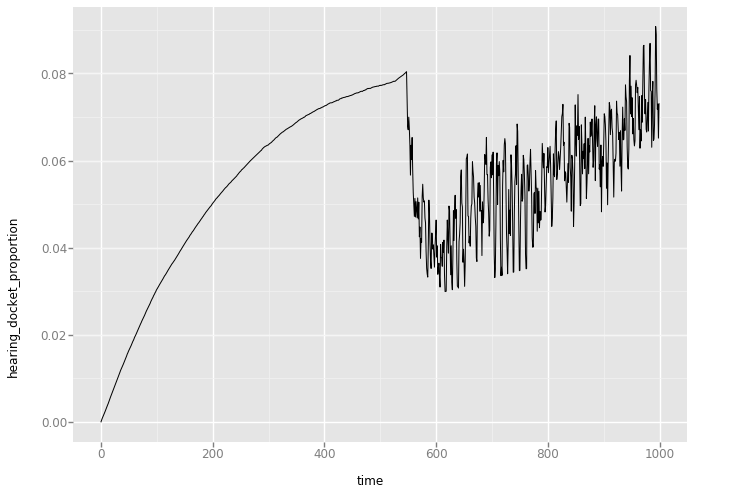

<ggplot: (313047609)>

In [44]:
ggplot(aes(x = 'time', y = 'hearing_docket_proportion'), days_df) + geom_line()

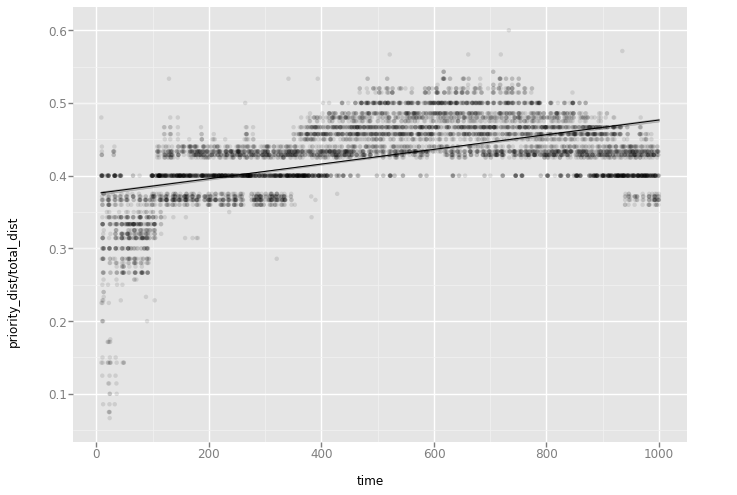

<ggplot: (296518127)>

In [30]:
ggplot(aes(x = 'time', y = 'priority_dist/total_dist'), batches_df) + geom_point(alpha = 0.1) + stat_smooth()

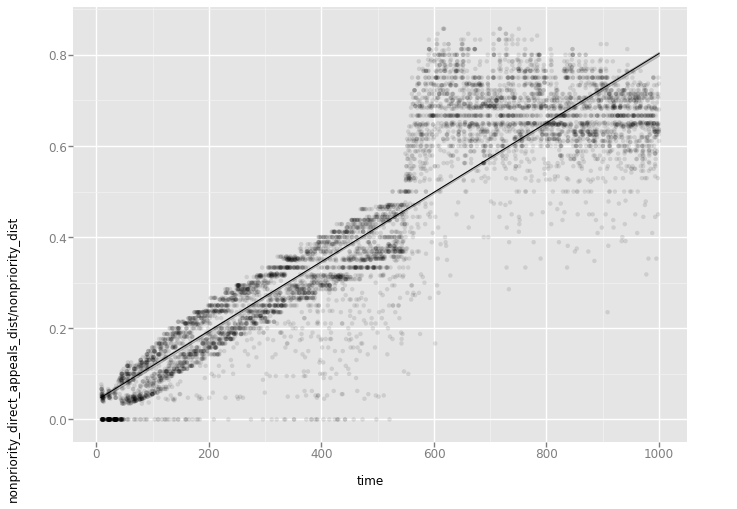

<ggplot: (311841821)>

In [31]:
ggplot(aes(x = 'time', y = 'nonpriority_direct_appeals_dist/nonpriority_dist'), batches_df) + geom_point(alpha = 0.1) + stat_smooth(method='lm')

In [38]:
hearing_df

,hearing_docket_count,nonpriority_ama_scheduled,nonpriority_hearing_docket_count,priority_ama_scheduled,time
0,8971,494,7232,1739,90
1,15622,828,13694,1826,180
2,21828,1070,19957,1740,270
3,27833,1237,25944,1775,360
4,33821,1333,31810,1899,450
5,39975,1412,37745,2105,540
6,46003,676,43662,2219,630
7,52599,1066,50256,2216,720
8,58878,1093,56590,2155,810
9,65287,1129,62895,2253,900
